<a href="https://colab.research.google.com/github/aniketgupta1997/Layerwise-Relevance-Propagation/blob/master/Devanagari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Importing Modules
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

In [4]:
num_classes = 18
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract('Train.tar')

Extracting data for Train. This may take a while. Please wait.
['Train/character_11_taamatar', 'Train/character_13_daa', 'Train/character_16_tabala', 'Train/character_18_da', 'Train/character_1_ka', 'Train/character_21_pa', 'Train/character_25_ma', 'Train/character_26_yaw', 'Train/character_27_ra', 'Train/character_28_la', 'Train/character_29_waw', 'Train/character_30_motosaw', 'Train/character_32_patalosaw', 'Train/character_33_ha', 'Train/character_3_ga', 'Train/character_4_gha', 'Train/character_6_cha', 'Train/character_8_ja']


In [5]:
image_size = 32  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (plt.imread(image_file,0).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 1700)

Pickling Train/character_11_taamatar.pickle.
Train/character_11_taamatar
Full dataset tensor: (1700, 32, 32)
Mean: -0.2863805
Standard deviation: 0.37165746
Pickling Train/character_13_daa.pickle.
Train/character_13_daa
Full dataset tensor: (1700, 32, 32)
Mean: -0.25994468
Standard deviation: 0.38653943
Pickling Train/character_16_tabala.pickle.
Train/character_16_tabala
Full dataset tensor: (1700, 32, 32)
Mean: -0.28474542
Standard deviation: 0.37382212
Pickling Train/character_18_da.pickle.
Train/character_18_da
Full dataset tensor: (1700, 32, 32)
Mean: -0.2827079
Standard deviation: 0.37258044
Pickling Train/character_1_ka.pickle.
Train/character_1_ka
Full dataset tensor: (1700, 32, 32)
Mean: -0.20172723
Standard deviation: 0.41384917
Pickling Train/character_21_pa.pickle.
Train/character_21_pa
Full dataset tensor: (1700, 32, 32)
Mean: -0.29097578
Standard deviation: 0.36987484
Pickling Train/character_25_ma.pickle.
Train/character_25_ma
Full dataset tensor: (1700, 32, 32)
Mean: -0.

In [6]:
print(train_datasets)

['Train/character_11_taamatar.pickle', 'Train/character_13_daa.pickle', 'Train/character_16_tabala.pickle', 'Train/character_18_da.pickle', 'Train/character_1_ka.pickle', 'Train/character_21_pa.pickle', 'Train/character_25_ma.pickle', 'Train/character_26_yaw.pickle', 'Train/character_27_ra.pickle', 'Train/character_28_la.pickle', 'Train/character_29_waw.pickle', 'Train/character_30_motosaw.pickle', 'Train/character_32_patalosaw.pickle', 'Train/character_33_ha.pickle', 'Train/character_3_ga.pickle', 'Train/character_4_gha.pickle', 'Train/character_6_cha.pickle', 'Train/character_8_ja.pickle']


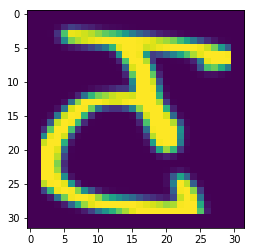

In [7]:
pickle_file = train_datasets[0]  

# With would automatically close the file after the nested block of code
with open(pickle_file, 'rb') as f:
    
    # unpickle
    letter_set = pickle.load(f)  
    
    # pick a random image index
    sample_idx = np.random.randint(len(letter_set))
    
    # extract a 2D slice
    sample_image = letter_set[sample_idx, :, :]  
    plt.figure()
    
    # display it
    plt.imshow(sample_image)  

In [8]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 30600
valid_size = 0


valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)

print('Training:', train_dataset.shape, train_labels.shape)

Training: (30600, 32, 32) (30600,)


In [0]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)


In [0]:
train_dataset = train_dataset.reshape(train_dataset.shape[0],1024)
# standardize the features
sc = StandardScaler()
X_train_std = sc.fit_transform(train_dataset)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# intialize pca and logistic regression model
pca = PCA(n_components=2)
lr = LogisticRegression(multi_class='auto', solver='liblinear')

# fit and transform data
X_train_pca_2 = pca.fit_transform(X_train_std)
lr.fit(X_train_pca, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

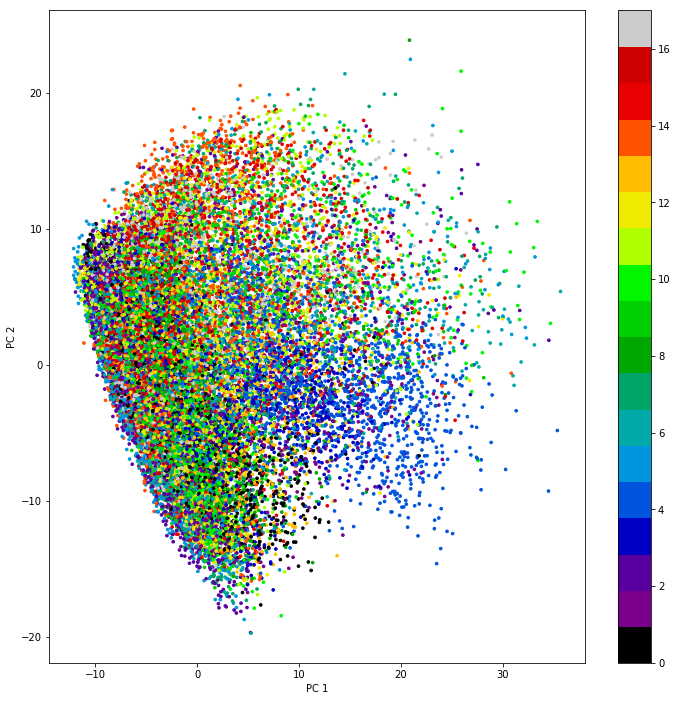

In [12]:
plt.figure(figsize=[12,12])
plt.scatter(X_train_pca_2[:, 0], X_train_pca_2[:, 1], c=train_labels,cmap=plt.cm.get_cmap('nipy_spectral',18),s = 7 )
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()

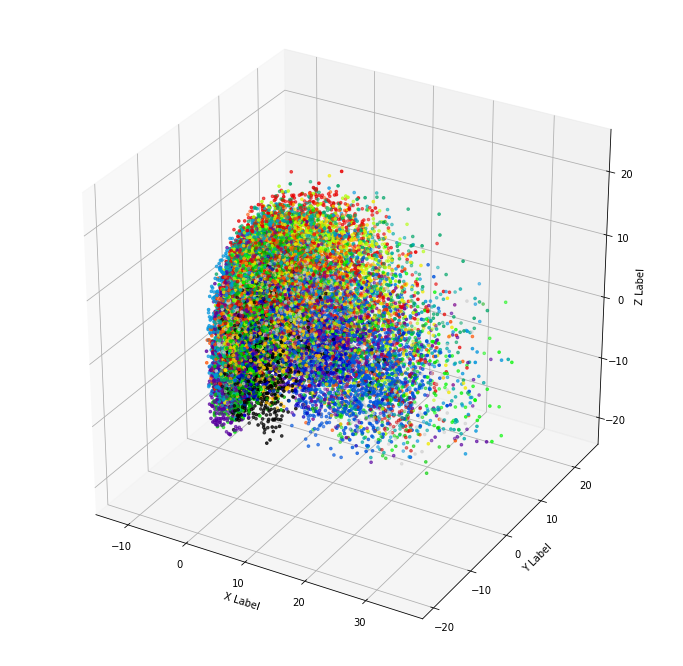

In [20]:
from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components=3)
lr = LogisticRegression(multi_class='auto', solver='liblinear')

# fit and transform data
X_train_pca_3 = pca.fit_transform(X_train_std)
lr.fit(X_train_pca_3, train_labels)


fig = plt.figure(figsize=[12,12])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_pca_3[:, 0], X_train_pca_3[:, 1],X_train_pca_3[:, 2], zdir='X_train_pca_3[:, 2]', c=train_labels,cmap=plt.cm.get_cmap('nipy_spectral',18),s = 7 )
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

In [21]:
import numpy as np
from sklearn.manifold import TSNE
X_tsne_2 = TSNE(n_components=2).fit_transform(X_train_std)
lr.fit(X_tsne_2, train_labels)
X_tsne_2.shape


(30600, 2)

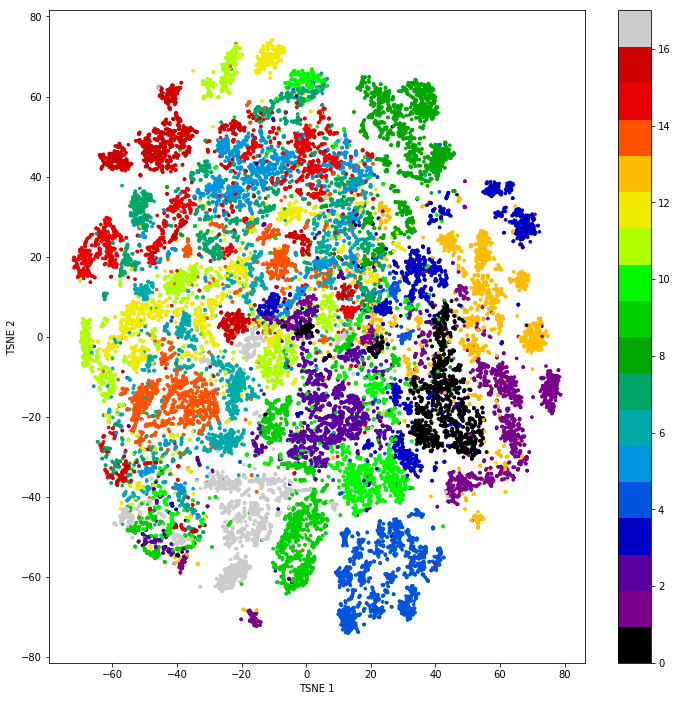

In [25]:
plt.figure(figsize=[12,12])
plt.scatter(X_tsne_2[:, 0], X_tsne_2[:, 1], c=train_labels,cmap=plt.cm.get_cmap('nipy_spectral',18),s = 7 )
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.colorbar()

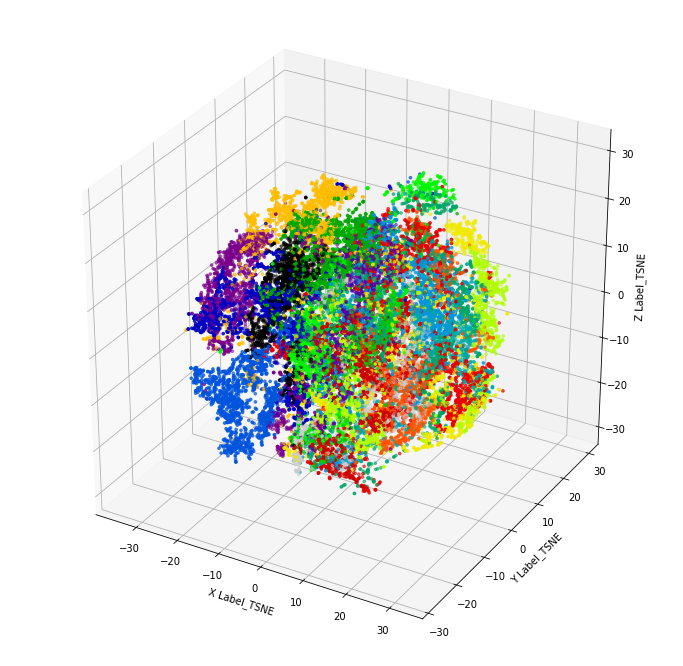

In [24]:
X_tsne_3 = TSNE(n_components=3).fit_transform(X_train_std)
lr.fit(X_tsne_3, train_labels)
X_tsne_3.shape

fig = plt.figure(figsize=[12,12])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_tsne_3[:, 0], X_tsne_3[:, 1],X_tsne_3[:, 2], zdir='X_tsne_3[:, 2]', c=train_labels,cmap=plt.cm.get_cmap('nipy_spectral',18),s = 7 )
ax.set_xlabel('X Label_TSNE')
ax.set_ylabel('Y Label_TSNE')
ax.set_zlabel('Z Label_TSNE')
plt.show()

In [0]:
pca = PCA(n_components=50)


# fit and transform data
X_train_pca_temp = pca.fit_transform(X_train_std)




In [27]:
#lr2 = LogisticRegression(multi_class='auto', solver='liblinear')
X_pca_tsne_2 = TSNE(n_components=2).fit_transform(X_train_pca_temp)
#lr2.fit(X_pca_tsne_2, train_labels)
X_pca_tsne_2.shape



(30600, 2)

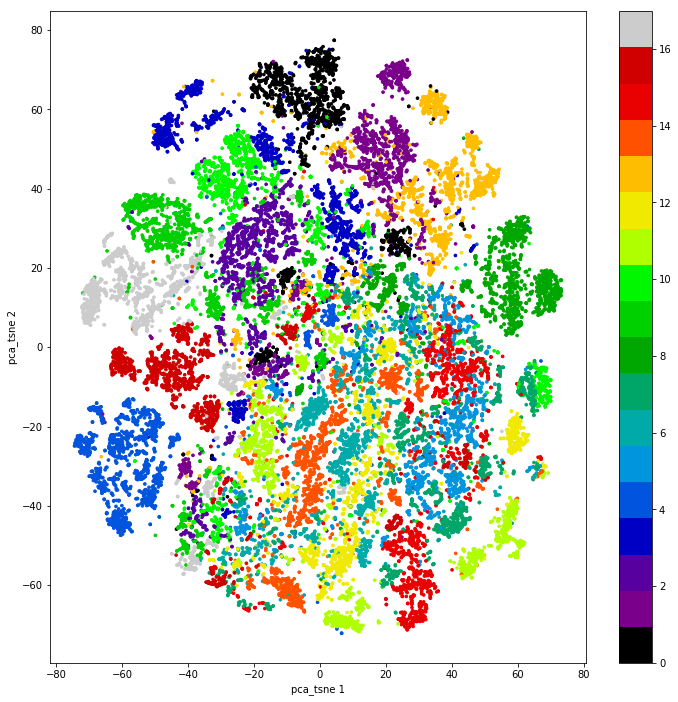

In [28]:
plt.figure(figsize=[12,12])
plt.scatter(X_pca_tsne_2[:, 0], X_pca_tsne_2[:, 1], c=train_labels,cmap=plt.cm.get_cmap('nipy_spectral',18),s = 7 )
plt.xlabel('pca_tsne 1')
plt.ylabel('pca_tsne 2')
plt.colorbar()

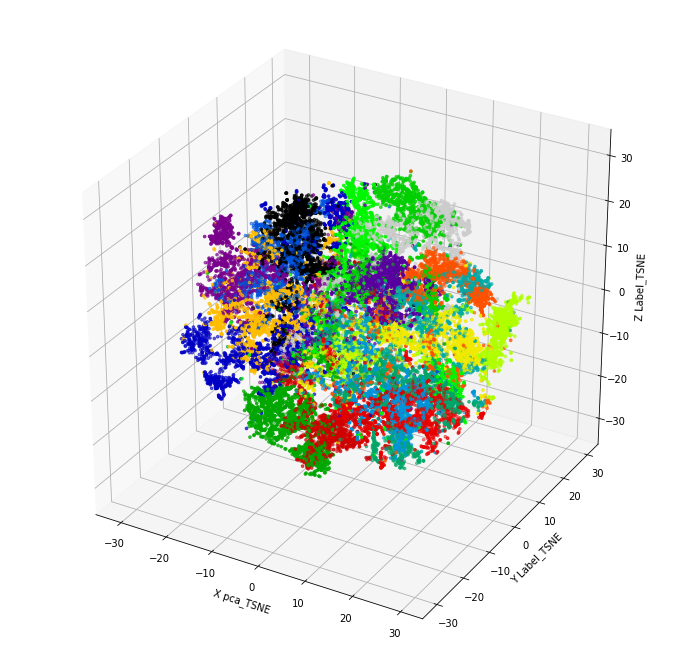

In [29]:
#lr2 = LogisticRegression(multi_class='auto', solver='liblinear')
X_pca_tsne_3 = TSNE(n_components=3).fit_transform(X_train_pca_temp)
#lr2.fit(X_pca_tsne_2, train_labels)
X_pca_tsne_3.shape


fig = plt.figure(figsize=[12,12])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_tsne_3[:, 0], X_pca_tsne_3[:, 1],X_pca_tsne_3[:, 2], zdir='X_pca_tsne_3[:, 2]', c=train_labels,cmap=plt.cm.get_cmap('nipy_spectral',18),s = 7 )
ax.set_xlabel('X pca_TSNE')
ax.set_ylabel('Y Label_TSNE')
ax.set_zlabel('Z Label_TSNE')
plt.show()

1